# Multi-objective Printing Optimization for 3 nominally identical 3D printers case study

written by Christina Schenk

last updated on 21 Oct 2025

tested on Christina's Mac

This notebook creates suggestions for the pure exploitation phase for performing Bayesian optimization for optimizing printing parameters targeting weight/density.

It involves noise estimation for the noise coming from three nominally identical 3D printers and involving multiple repetitions (sequential and simultaneous) as presented in "Noise-Aware Optimization in Nominally Identical Measuring Systems for High-Throughput Parallel Workflows Manuscript" by Christina Schenk et al. (2025). 

The steps of the workflow are the following:

1. Define design setting
2. Data import and formatting
3. Customizing GP
4. Initialization of the BO parameters
5. BO phase: batch of 3, Max acquisition function, fvGPOptimizer
6. Evaluate results and plot contours
7. Save suggestions to file
8. Plotting pareto front
9. Capture likelihood and hps output and save metadata

In [1]:
import os
from numpy import arange
from numpy import meshgrid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gpcam.gp_optimizer import fvGPOptimizer

import random
import sys

# sys.path.append('../src/')
# #from plot import contourplot_mean_cov_acq
# from plot import tracking_contourplot_mean_cov_acq
# from plot import tracking_contourplot_mean_cov
#from plot import trackplot_3d_mean_cov_acq
import plotly.graph_objects as go

from scipy.stats import norm
from itertools import combinations
import itertools as it
#for plot library:
#pip install opencv-python 

import platform
import yaml
import time
import io
import random

import ast
import re
import math


### Plotting functions

In [2]:
""" Contour plot multiplot for comparison of inputs and outputs for plotting mean, covariance and acquisition.
    
        Parameters
        ----------
        X: input points (where we want to make predictions) first component in grid format
        Y: input points (where we want to make predictions) second component in grid format
        f_mean_re: reshaped posterior mean values
        f_cov_re:reshaped posterior covariance values
        f_acq_re:reshaped acquisition values
        data: data points
        iteration: integer, current iteration number
        figurepath: string for path to folder where plots should be saved
        title1: plot title string, e.g. Posterior mean, 
        title2: plot title string, e.g. Posterior covariance
        title3: plot title string, e.g. Acquisition
        titlexaxis: string of title for xaxis, default x (%)
        titleyaxis: string of title for yaxis, default y (%)
        
        Returns
        -------
        Contour plot multiplot for comparison of inputs and outputs for plotting mean, covariance and acquisition.
        
"""
#contourplot mean, covariance, acquistion function:
def tracking_contourplot_mean_cov_acq(X, Y, f_mean_re, f_cov_re, f_acq_re, data, iteration, figurepath, title1="", title2="", title3="",  titlexaxis="x (%)", titleyaxis="y (%)", batchsize = 1, task=1, taskname = None):
    fig, ax = plt.subplots(1, 3, figsize=(12,4))
    cp1 = ax[0].contourf(X, Y, f_mean_re)
    cp2 = ax[1].contourf(X, Y, f_cov_re)
    cp3 = ax[2].contourf(X, Y, f_acq_re)
    if data is not None:
        ax[0].scatter(x=data[:, 0], y=data[:, 1])
        ax[0].scatter(x=data[-batchsize:, 0], y=data[-batchsize:, 1], c='r')
        ax[1].scatter(x=data[:, 0], y=data[:, 1])
        ax[1].scatter(x=data[-batchsize:, 0], y=data[-batchsize:, 1], c='r')
        ax[2].scatter(x=data[:, 0], y=data[:, 1])
        ax[2].scatter(x=data[-batchsize:, 0], y=data[-batchsize:, 1], c='r')
    fig.colorbar(cp1, ax=ax[0])# Add a colorbar to a plot
    fig.colorbar(cp2, ax=ax[1])# Add a colorbar to a plot
    fig.colorbar(cp3, ax=ax[2])# Add a colorbar to a plot
    fig.tight_layout(pad=5.0)
    ax[0].set_title(title1+'\n')
    ax[1].set_title(title2+'\n')
    ax[2].set_title(title3+'\n')
    ax[0].set_ylabel(titleyaxis)
    ax[0].set_xlabel(titlexaxis)
    ax[1].set_ylabel(titleyaxis)
    ax[1].set_xlabel(titlexaxis)
    ax[2].set_ylabel(titleyaxis)
    ax[2].set_xlabel(titlexaxis)
    if taskname:
        fig.suptitle(taskname+'\n', fontsize=20)
    plt.savefig(os.path.join(figurepath,"plot"+str(iteration)+"T"+str(task)+".JPG"))
    plt.show()  
    
    
""" Tracking plot multiplot for comparison of inputs and outputs for plotting mean in one plot and acquisition in another first for x and then for y.
    
        Parameters
        ----------
        x: input points (where we want to make predictions) first component in grid format
        y: input points (where we want to make predictions) second component in grid format
        points: original data plus new sample points
        mean_points: posterior mean at points
        acq_points: acquistion at points
        f_mean: reshaped posterior mean values
        f_acq: reshaped acquisition values
        f_cov:reshaped posterior covariance values
        f_acq_re:reshaped acquisition values
        data: data points, e.g. np.column_stack([points[:,0], points[:,1]]
        iteration: integer, current iteration number
        title1: plot title string, e.g. Posterior mean+covariance
        title2: plot title string, e.g. Acquisition
        batchsize: number of newly generated points, so they are plotted in a different color
        task: number of task for the multitasking case
        taskname: name of the task for the multitasking case
        Returns
        -------
        Tracking plot multiplot for comparison of inputs and outputs for plotting mean in one plot and acquisition in another first for x and then for y.
"""

#contourplot mean, covariance:
def tracking_contourplot_mean_cov(X, Y, f_mean_re, f_cov_re, data, iteration, figurepath, title1="", title2="",  titlexaxis="x (%)", titleyaxis="y (%)", batchsize = 1, task=1, taskname = None):
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    cp1 = ax[0].contourf(X, Y, f_mean_re)
    cp2 = ax[1].contourf(X, Y, f_cov_re)
    if data is not None:
        ax[0].scatter(x=data[:, 0], y=data[:, 1])
        ax[0].scatter(x=data[-batchsize:, 0], y=data[-batchsize:, 1], c='r')
        ax[1].scatter(x=data[:, 0], y=data[:, 1])
        ax[1].scatter(x=data[-batchsize:, 0], y=data[-batchsize:, 1], c='r')
    fig.colorbar(cp1, ax=ax[0])# Add a colorbar to a plot
    fig.colorbar(cp2, ax=ax[1])# Add a colorbar to a plot
    fig.tight_layout(pad=5.0)
    ax[0].set_title(title1+'\n')
    ax[1].set_title(title2+'\n')
    ax[0].set_ylabel(titleyaxis)
    ax[0].set_xlabel(titlexaxis)
    ax[1].set_ylabel(titleyaxis)
    ax[1].set_xlabel(titlexaxis)
    if taskname:
        fig.suptitle(taskname+'\n', fontsize=20)
    plt.savefig(os.path.join(figurepath,"plot"+str(iteration)+"T"+str(task)+".JPG"))
    plt.show()  

### Kernel function

In [3]:
def matern_kernel_diff1(distance, length):
    """
    Function for the matern kernel, order of differentiablity = 1.
    kernel = (1.0 + ((np.sqrt(3.0) * distance) / (length))) * np.exp(
        -(np.sqrt(3.0) * distance) / length

    Parameters
    ----------
    distance : scalar or np.ndarray
        Distance between a set of points.
    length : scalar
        The length scale hyperparameters

    Return
    ------
    A structure of the shape of the distance input parameter : float or np.ndarray
    """

    kernel = (1.0 + ((np.sqrt(3.0) * distance) / (length))) * np.exp(
        -(np.sqrt(3.0) * distance) / length
    )
    return kernel
    
def kernel_mat32_816(x1,x2,hyperparameters):
    """
    Function for the default kernel, a Matern kernel of first-order differentiability.

    Parameters
    ----------
    x1 : np.ndarray
        Numpy array of shape (U x D)
    x2 : np.ndarray
        Numpy array of shape (V x D)
    hyperparameters : np.ndarray
        Array of hyperparameters. For this kernel we need D + 1 hyperparameters
    obj : object instance
        GP object instance.

    Return
    ------
    A structure of the shape of the distance input parameter : float or np.ndarray
    """
    hps = hyperparameters
    distance_matrix = np.zeros((len(x1),len(x2)))
    for i in range(len(x1[0])):
        distance_matrix += abs(np.subtract.outer(x1[:,i],x2[:,i])/hps[1+i])**2
    distance_matrix = np.sqrt(distance_matrix)
    return hps[0] * matern_kernel_diff1(distance_matrix,1)

### Acquisition function

In [4]:
def maximum_acq_func_3printers(x,obj):
     #multi-task autonomous experiments should make use of a user-defined acquisition function to
    #make full use of the surrogate and the uncertainty in all tasks.
    task0 = 0.
    task1 = 1.
    task2 = 2.
    x_out = np.array([task0,task1,task2])
    res = obj.posterior_mean(x, x_out=x_out)["f(x)"]
    return np.sum(res.reshape(len(x), len(x_out)), axis=1)

## 1. Define design setting

In [5]:
#Lower and upper bounds for the parameters:
#speed fixed at 100 and LW at 0.8
f_lb = 1000
f_ub = 5000
lh_lb = 0.2
lh_ub = 0.6

#number of points in x and y direction at which we want to predict:
n_pts = 100

#number of autonomous experiments that you would like to run:
N_exp = 3

#dimension of design space:
dim = 2

n_batch = int(input("Introduce batch number:"))
is_this_a_test = input("Is this a test? y/n")

Introduce batch number: 2
Is this a test? y/n n


## 2. Data

Check that the data is the desired one before running the experiment

In [7]:
dataset = "data/3printers_Oct2024_data_noise_reformattedtasks_all_" +str(n_batch-1) + ".xlsx"
df = pd.read_excel(dataset,header=0)
df = df.iloc[:, :7]
df.iloc[:,0] = round(df.iloc[:,0])
df.iloc[:,1] = round(df.iloc[:,1],2)
data_array_expl = np.array(df)
np.save('data/data_exploration.npy', data_array_expl)
data_path = "data"
data_npy = np.load(os.path.join(data_path,"data_exploration.npy"), allow_pickle=True)
points = data_npy[:,0:2]

#Calculate DeltaWs:
volume = 80 * 13 * 3.2 * 1e-3
expected_density = 1.24 #from the PLA datasheet 
#https://www.materialdatacenter.com/ms/en/Ingeo/NatureWorks+LLC/Ingeo%E2%84%A2+3251D/f483c129/5616
expected_weight = volume * expected_density
W_P1 = - abs(1-data_npy[:,4]/expected_weight)
W_P2 = - abs(1-data_npy[:,5]/expected_weight)
W_P3 = - abs(1-data_npy[:,6]/expected_weight)
values = np.column_stack(([W_P1,W_P2,W_P3]))

y_data1 = values[:,0]
y_data2 = values[:,1]
y_data3 = values[:,2]

### Read hps from metadata file to reuse here and not start training from scratch, and read max acquistion value for tasks

In [8]:
with open('Metadata/metadata_after_BO'+str(n_batch-1) +'.yaml', 'r') as file:
    metadata_1 = yaml.safe_load(file)

In [9]:
original_hps_str = metadata_1["hps after BO after training"]
fixed_hps_str = original_hps_str.strip('[]')
fixed_hps_str = re.sub(r'\s+', ', ', fixed_hps_str)  # Add commas between values

# Add brackets back
fixed_hps_str = f'[{fixed_hps_str}]'

# Convert the formatted string to a Python list
try:
    list_data = ast.literal_eval(fixed_hps_str)
except (ValueError, SyntaxError) as e:
    print(f"Error parsing string: {e}")
    list_data = []
    
# Convert to a NumPy array
array_1d = np.array(list_data)

In [10]:
prev_maxacq_task0 = metadata_1["maxacq_task0"]
prev_maxacq_task1 = metadata_1["maxacq_task1"]
prev_maxacq_task2 = metadata_1["maxacq_task2"]

## 3. Customizing a Gaussian Process

#### Import/Specify kernel that want to use

In [11]:
my_kernel_2 = kernel_mat32_816

In [12]:
def my_noise_consttasks(x, hps):
    # Check that the last column contains only allowed values
    allowed_values = np.array([0.0, 0.15, 1.0, 0.35, 2.0, 0.5])
    if not np.all(np.isin(x[:, -1], allowed_values)):
        raise ValueError("x[:, -1] must contain either 0, 0.15 or 1, 0.35 or 2, 0.5")

    # Create a mask for each condition and assign noise parameters accordingly
    mask_0_0_0 = np.isin(x[:, -1], [0.0, 0.15])
    mask_1_0_1 = np.isin(x[:, -1], [1.0, 0.35])
    mask_2_0_2 = np.isin(x[:, -1], [2.0, 0.5])
    noise_params = np.zeros(x.shape[0])
    noise_params[mask_0_0_0] = hps[-3]
    noise_params[mask_1_0_1] = hps[-2]
    noise_params[mask_2_0_2] = hps[-1]
    return noise_params

In [13]:
my_noise = my_noise_consttasks

#### Define some points at which we will predict, still has nothing to do with gpCAM 

In [14]:
x_pred = np.zeros((n_pts*n_pts,2))
x = np.linspace(f_lb,f_ub,n_pts)
y = np.linspace(lh_lb,lh_ub,n_pts)
X,Y = np.meshgrid(x,y)
counter = 0
for i in  range(n_pts):
    for j in range(n_pts):
        x_pred[counter] = np.array([X[i,j],Y[i,j]])
        counter += 1
x_pred_acq = np.array(list(it.product(np.linspace(f_lb,f_ub,n_pts),np.linspace(lh_lb,lh_ub, n_pts))))

## 4. Initialization of the BO parameters

In [15]:
parameter_bounds = np.array([[f_lb, f_ub],[lh_lb, lh_ub]])
guess1 = 100
guess2 = 1
guess3 = 1
guess4 = 100
guess5 = 0.01
guess6 = 1.
guess7 = 1.

#stat kernel:
hps_guess_2 = np.array([guess1, guess2, guess3, guess3, guess5, guess5, guess5]) #nonstat printid #guess6, guess7,
#hps_guess = np.array([guess1, guess2, guess3, guess6, guess7, guess6, guess7, guess5]) #nonstat printid and rep
hps_bounds_2 = np.array([[0.00001,100000.], #signal variance for the kernel
                       [1.,10000.], #length scale 1 for the kernel
                       [0.001,10.], #length scale 2 for the kernel
                       [0.01,10.], #length scale for task dimension
                       [0.0001,1],  #noise task1
                       [0.0001,1],  #noise task2
                       [0.0001,1]  #noise task3
                       ])

### Use last hps from previous batch

In [16]:
hps_guess_2 = array_1d
print(hps_guess_2)

[5.54627187e-03 1.23734987e+02 2.65074681e-01 3.69512383e-01
 1.55745360e-03 1.99068986e-03 2.56838574e-03]


## 5. Exploitation phase: batch of 3, maximum acquisition function, fvGPOptimizer

### 5.1 GP Training

In [17]:
start_time = time.time()
y_list = []
output_pos1 = []
for i in range(len(y_data1)):
    if (math.isnan(y_data1[i])==False and math.isnan(y_data3[i])==True and math.isnan(y_data2[i])==True):
        y_list.append([y_data1[i]])
        output_pos1.append([0.15])
    elif (math.isnan(y_data1[i])==True and math.isnan(y_data3[i])==True and math.isnan(y_data2[i])==False):
        y_list.append([y_data2[i]])
        output_pos1.append([0.35])
    elif (math.isnan(y_data1[i])==True and math.isnan(y_data3[i])==False and math.isnan(y_data2[i])==True):
        y_list.append([y_data3[i]])
        output_pos1.append([0.5])
    else:
        y_list.append([y_data1[i], y_data2[i], y_data3[i]])
        output_pos1.append([0.15,0.35,0.5])
values = y_list  

output_pos2 = []
for k in range(len(y_data1)):
    if (math.isnan(y_data1[k])==False and math.isnan(y_data3[k])==True and math.isnan(y_data2[k])==True):
        output_pos2.append([0])
    elif (math.isnan(y_data1[k])==True and math.isnan(y_data3[k])==True and math.isnan(y_data2[k])==False):
        output_pos2.append([1])
    elif (math.isnan(y_data1[k])==True and math.isnan(y_data2[k])==True and math.isnan(y_data3[k])==False):
        output_pos2.append([2])
    else:
        output_pos2.append([0,1,2])
              
my_gp2 = fvGPOptimizer(points, values,
        init_hyperparameters = hps_guess_2,  # we need enough of those for kernel, noise and prior mean functions
        output_positions = output_pos2,
        #hyperparameter_bounds = hps_bounds_2,
        #noise_variances=vars, # providing noise variances and a noise function will raise a warning 
        #compute_device='cpu',
        gp_kernel_function=my_kernel_2,
        #gp_kernel_function_grad=None, 
        gp_noise_function=my_noise
        #info=True
        )

#comment out .tell and train if using deepGP
#my_gp2.tell(points, values, append=False, output_positions=output_pos)#, noise_variances=np.ones(points.shape) * std_impact)
print("loglikelihood 2", my_gp2.log_likelihood())
my_gp2.train(hyperparameter_bounds=hps_bounds_2)
print("loglikelihood 2 after", my_gp2.log_likelihood())
print("hps: ", my_gp2.get_hyperparameters())
end_time = time.time()
time = end_time-start_time

loglikelihood 2 1222.1678270518123
loglikelihood 2 after 1223.3360120049924
hps:  [6.88886704e-03 2.15439408e+02 1.08337990e-01 3.73384819e-01
 1.72895185e-03 1.92252043e-03 2.73655547e-03]


In [18]:
my_kernel = my_kernel_2
hps_bounds = hps_bounds_2
hps_guess = hps_guess_2
my_gp = my_gp2
task0 = 0.
task1 = 1.
task2 = 2.
output_pos = output_pos2
my_acq_func = maximum_acq_func_3printers
loglikelihood = str(print(my_gp.log_likelihood()))

1223.3360120049924


### 5.2 Choose assignment/order of points to printers

In [19]:
#Choose random order of points to printer:
printers = [(1,2,3), (2,1,3), (3,1,2), (1,3,2), (2,3,1), (3,2,1)]
random_order = random.choice(printers)
print(random_order)

(1, 2, 3)


### 5.3 Capture likelihood and hps output and save metadata

In [20]:
# Step 1: Capture the printed output
output_capture = io.StringIO()
print_capture = print

# Redirect print to the StringIO object
print = lambda *args, **kwargs: print_capture(*args, **kwargs, file=output_capture)

# Call the function and capture the output
print(my_gp.log_likelihood())

# Reset print to original function
print = print_capture

# Get the printed value as a string
captured_output = output_capture.getvalue().strip()


# Step 1: Capture the printed output
output_capture_hps = io.StringIO()
print_capture_hps = print

# Redirect print to the StringIO object
print = lambda *args, **kwargs: print_capture_hps(*args, **kwargs, file=output_capture_hps)

# Call the function and capture the output
print(my_gp.get_hyperparameters())

# Reset print to original function
print = print_capture_hps

# Get the printed value as a string
captured_output_hps = output_capture_hps.getvalue().strip()

In [21]:
# Example metadata
if isinstance(my_acq_func, str):
    metadata = {
        "kernel": str(my_kernel), 
        "likelihood before BO after training": captured_output,
        "acqfunc": my_acq_func,
        "n_batch": n_batch,
        "n=1": "y",
        "gp training time stationary": time,
        "hps before BO after training": captured_output_hps,
        "order of points to printer": str(random_order)
    }
else:
     metadata = {
        "kernel": str(my_kernel), 
        "likelihood before BO after training": captured_output,
        "acqfunc": str(my_acq_func),
        "n_batch": n_batch,
        "n=1": "y",
        "gp training time stationary": time,
        "hps before BO after training": captured_output_hps,
        "order of points to printer": str(random_order)
    }
if not os.path.exists("./Metadata/"):
    # Create a new directory because it does not exist
    os.makedirs("./Metadata/")
    print("The new directory is created!")
    
# Save metadata to a YAML file
if is_this_a_test == 'y':
    with open("Metadata/metadata" + str(n_batch) + "_test.yaml", "w") as file:
        yaml.dump(metadata, file)
else:
    with open("Metadata/metadata" + str(n_batch) + ".yaml", "w") as file:
        yaml.dump(metadata, file)
#print("Metadata saved to metadata.yaml")

### 5.4 BO

351 351 351
acq <function maximum_acq_func_3printers at 0x140246700>
kernel <function kernel_mat32_816 at 0x140246040>
loglikelihood 1223.3360120049924
task indices 0.0 1.0 2.0
current pts [1.10948013e+03 4.90858973e-01]
current vals [-0.029785469350302102]
hps:  [6.88886704e-03 2.15439408e+02 1.08337990e-01 3.73384819e-01
 1.72895185e-03 1.92252043e-03 2.73655547e-03]
(10000,)


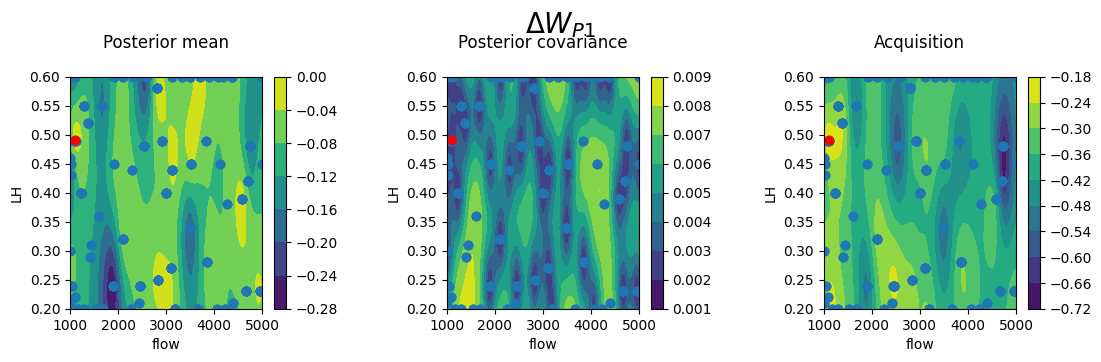

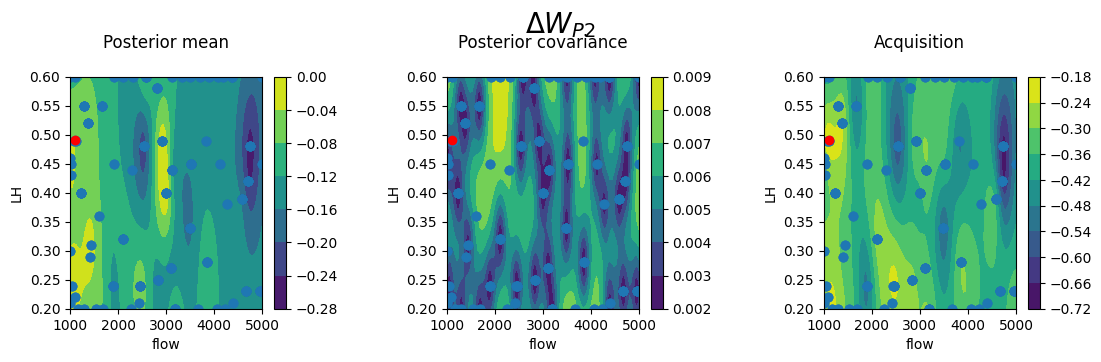

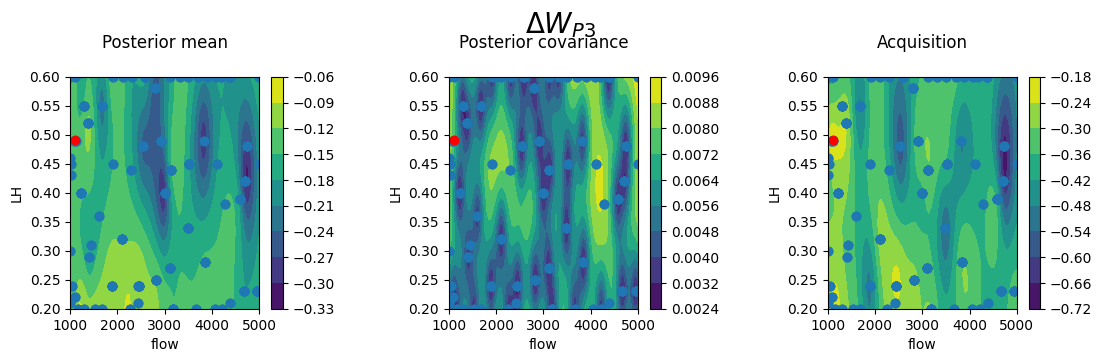

hps:  [8.18398834e-03 7.28526655e+02 4.50473274e-02 6.61083609e-01
 1.46070511e-03 1.74047745e-03 3.10687277e-03]
acq <function maximum_acq_func_3printers at 0x140246700>
kernel <function kernel_mat32_816 at 0x140246040>
loglikelihood 1224.5315463967493
task indices 0.0 1.0 2.0
current pts [1.00006939e+03 4.98573264e-01]
current vals [-0.029018041475545486]
hps:  [8.18398834e-03 7.28526655e+02 4.50473274e-02 6.61083609e-01
 1.46070511e-03 1.74047745e-03 3.10687277e-03]
(10000,)


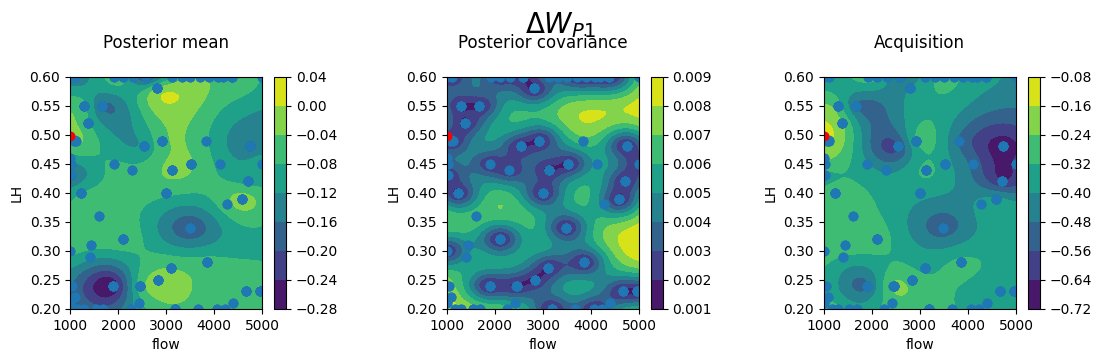

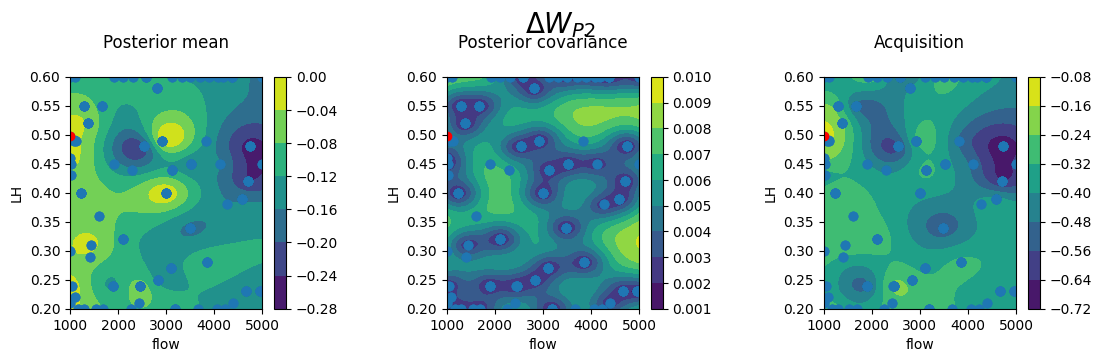

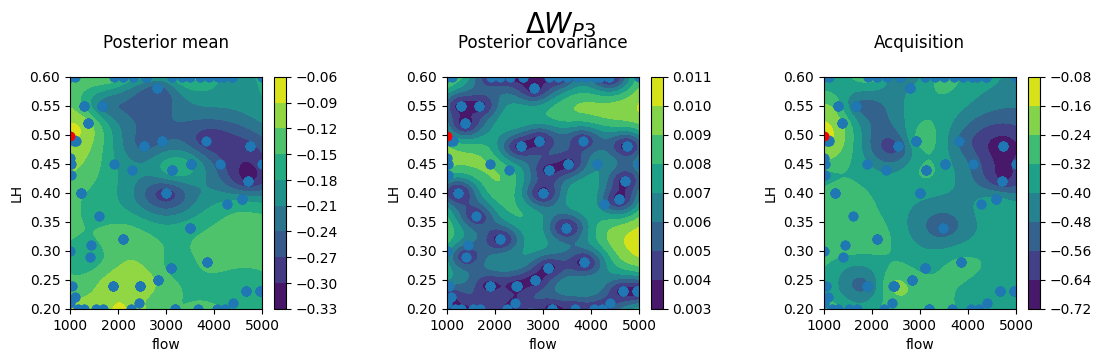

hps:  [4.33222401e-03 2.50612288e+02 1.34312852e-01 8.08925514e-01
 1.19449749e-03 1.87019304e-03 2.71068685e-03]
acq <function maximum_acq_func_3printers at 0x140246700>
kernel <function kernel_mat32_816 at 0x140246040>
loglikelihood 1230.0333720248018
task indices 0.0 1.0 2.0
current pts [1.10797264e+03 4.91683421e-01]
current vals [-0.1295173561374395]
hps:  [4.33222401e-03 2.50612288e+02 1.34312852e-01 8.08925514e-01
 1.19449749e-03 1.87019304e-03 2.71068685e-03]
(10000,)


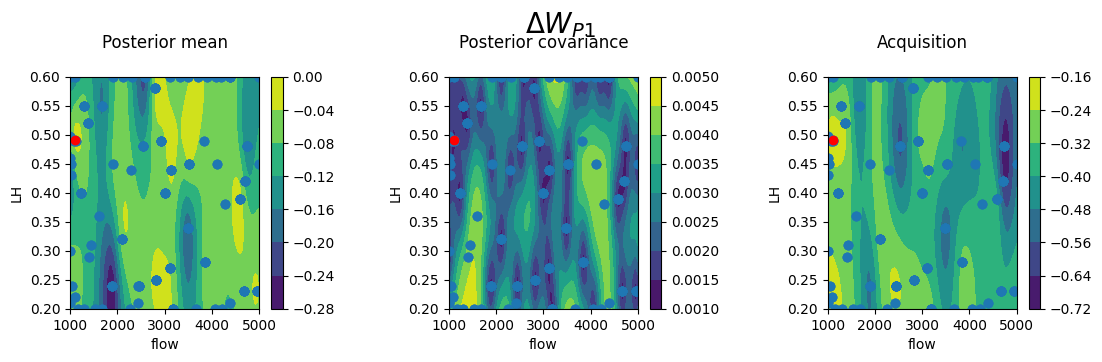

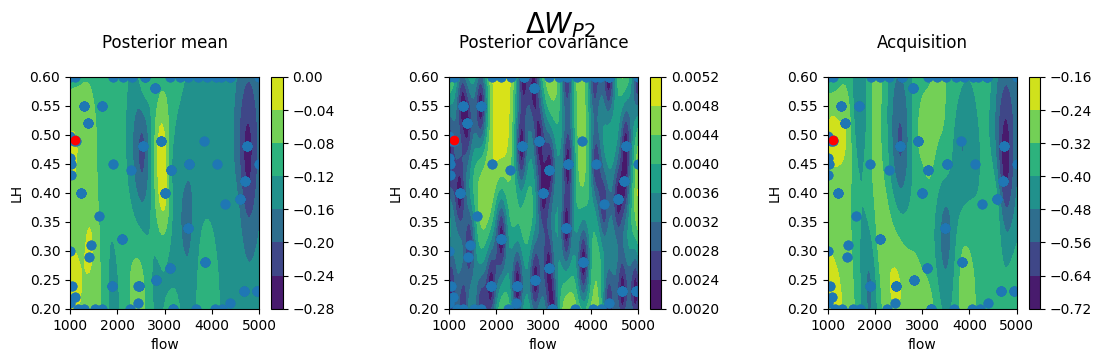

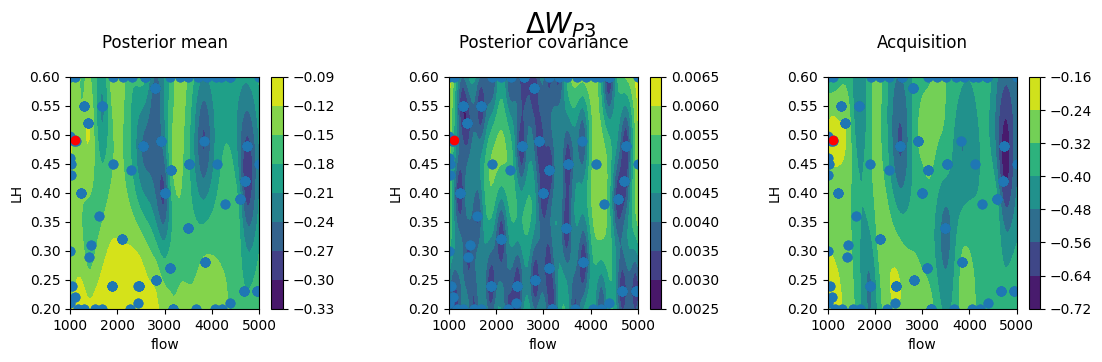

hps:  [4.78797765e-03 3.66855244e+02 8.65487137e-02 7.10749465e-01
 1.78804797e-03 2.08937355e-03 2.66006524e-03]


In [22]:
# Define the specific output positions for the printers
output_positions = {1: task0, 2: task1, 3: task2}  # Mapping printer IDs to their output positions
for i in range(N_exp):
    print("acq", my_acq_func)
    print("kernel", my_kernel)
    print("loglikelihood", my_gp.log_likelihood())
    print("task indices", task0, task1, task2)
    nextp = my_gp.ask(parameter_bounds, np.array([task0,task1,task2]), n = 1, acquisition_function=my_acq_func, method="global", vectorized=True)
    points = np.vstack((points, nextp['x']))
    print("current pts", points[-1])
    x = nextp['x']
    x_out = np.array([task0,task1,task2])
    
    value0 = my_gp.posterior_mean(x, x_out=np.zeros(1)+task0)["f(x)"]
    value1 = my_gp.posterior_mean(x, x_out=np.zeros(1)+task1)["f(x)"]
    value2 = my_gp.posterior_mean(x, x_out=np.zeros(1)+task2)["f(x)"]
    
    # Define the data corresponding to each printer
    # Assuming value0, value1, value2 are predefined arrays or lists
    data_printers = [value0, value1, value2]    
    # Iterate through the indices of the random order
    # Printer ID from random_order
    printer_id = random_order[i]
    
    # Append the corresponding data for the printer
    values.append(data_printers[printer_id - 1].flatten().tolist())
    
    # Append the specific continuous output position for this printer
    #print(output_positions[printer_id])
    output_pos.append([output_positions[printer_id]])
                    
    print("current vals", values[-1])
    print("hps: ", my_gp.get_hyperparameters())
    
    f_1 = my_gp.posterior_mean(x_pred, x_out = np.zeros(1)+task0)["f(x)"]
    f_2 = my_gp.posterior_mean(x_pred, x_out = np.zeros(1)+task1)["f(x)"]
    f_3 = my_gp.posterior_mean(x_pred, x_out = np.zeros(1)+task2)["f(x)"]

    f_cov_1 = my_gp.posterior_covariance(x_pred, x_out = np.zeros(1)+task0, variance_only=False, add_noise=True)["v(x)"]
    f_cov_2 = my_gp.posterior_covariance(x_pred, x_out = np.zeros(1)+task1, variance_only=False, add_noise=True)["v(x)"]
    f_cov_3 = my_gp.posterior_covariance(x_pred, x_out = np.zeros(1)+task2, variance_only=False, add_noise=True)["v(x)"]
    
    f_1_re = f_1.reshape(n_pts,n_pts)
    f_2_re = f_2.reshape(n_pts,n_pts)
    f_3_re = f_3.reshape(n_pts,n_pts)  
    
    f_cov_1_re = f_cov_1.reshape(n_pts,n_pts)
    f_cov_2_re = f_cov_2.reshape(n_pts,n_pts)
    f_cov_3_re = f_cov_3.reshape(n_pts,n_pts)
    
     # #Plot some results for tracking in each iteration:
    title1 = "Posterior mean"
    title2 = "Posterior covariance"
    title3 = "Acquisition"
    if is_this_a_test == 'y':
        figurepath = "./animatedfigure_2024/contourplots_composition_opt" + str(n_batch) + "_" + str(i) + "_test/"
    else:
        figurepath = "./animatedfigure_2024/contourplots_composition_opt" + str(n_batch) + "_" + str(i) + "/"

    if not os.path.exists(figurepath):
        # Create a new directory because it does not exist
        os.makedirs(figurepath)
        print("The new directory is created!")
        

    if my_acq_func=="relative information entropy" or my_acq_func=="relative information entropy set" or my_acq_func=="total correlation":
        tracking_contourplot_mean_cov(X, Y, f_1_re, f_cov_1_re, np.column_stack([points[:,0], points[:,1]]), 
                                          i, figurepath, title1, title2, titlexaxis="flow", titleyaxis="LH", batchsize=1, task=1, taskname = "$\Delta W_{P1}$")
        tracking_contourplot_mean_cov(X, Y, f_2_re, f_cov_2_re, np.column_stack([points[:,0], points[:,1]]), 
                                          i, figurepath, title1, title2, titlexaxis="flow", titleyaxis="LH", batchsize=1, task=2, taskname = "$\Delta W_{P2}$")
        tracking_contourplot_mean_cov(X, Y, f_3_re, f_cov_3_re, np.column_stack([points[:,0], points[:,1]]), 
                                          i, figurepath, title1, title2, titlexaxis="flow", titleyaxis="LH", batchsize=1, task=3, taskname = "$\Delta W_{P3}$")
    else:
        f_acq_1 = my_gp.evaluate_acquisition_function(x_pred, x_out = np.zeros(1)+task0, acquisition_function=my_acq_func)
        f_acq_2 = my_gp.evaluate_acquisition_function(x_pred, x_out = np.zeros(1)+task1, acquisition_function=my_acq_func)
        f_acq_3 = my_gp.evaluate_acquisition_function(x_pred, x_out = np.zeros(1)+task2, acquisition_function=my_acq_func)
        print(np.shape(f_acq_1))
        f_acq_1_re = f_acq_1.reshape(n_pts, n_pts)
        f_acq_2_re = f_acq_2.reshape(n_pts, n_pts)
        f_acq_3_re = f_acq_3.reshape(n_pts, n_pts)
        tracking_contourplot_mean_cov_acq(X, Y, f_1_re, f_cov_1_re, f_acq_1_re, np.column_stack([points[:,0], points[:,1]]), 
                                          i, figurepath, title1, title2, title3, titlexaxis="flow", titleyaxis="LH", batchsize=1, task=1, taskname = "$\Delta W_{P1}$")
        tracking_contourplot_mean_cov_acq(X, Y, f_2_re, f_cov_2_re, f_acq_2_re, np.column_stack([points[:,0], points[:,1]]), 
                                          i, figurepath, title1, title2, title3, titlexaxis="flow", titleyaxis="LH", batchsize=1, task=2, taskname = "$\Delta W_{P2}$")
        tracking_contourplot_mean_cov_acq(X, Y, f_3_re, f_cov_3_re, f_acq_3_re, np.column_stack([points[:,0], points[:,1]]), 
                                          i, figurepath, title1, title2, title3, titlexaxis="flow", titleyaxis="LH", batchsize=1, task=3, taskname = "$\Delta W_{P3}$")
   
    my_gp.tell(points, values, append=False, output_positions=output_pos)#, noise_variances=np.ones(points.shape) * std_impact)
    my_gp.train(hyperparameter_bounds=hps_bounds)
    print("hps: ", my_gp.get_hyperparameters())
    

In [23]:
#for changing print order based on higher values of acq fctn for printer:
maxall = {
    1: [
        max(my_gp.evaluate_acquisition_function(points[-3, :], x_out=np.zeros(1) + task0, acquisition_function=my_acq_func)),
        max(my_gp.evaluate_acquisition_function(points[-2, :], x_out=np.zeros(1) + task0, acquisition_function=my_acq_func)),
        max(my_gp.evaluate_acquisition_function(points[-1, :], x_out=np.zeros(1) + task0, acquisition_function=my_acq_func))
    ],
    2: [
        max(my_gp.evaluate_acquisition_function(points[-3, :], x_out=np.zeros(1) + task1, acquisition_function=my_acq_func)),
        max(my_gp.evaluate_acquisition_function(points[-2, :], x_out=np.zeros(1) + task1, acquisition_function=my_acq_func)),
        max(my_gp.evaluate_acquisition_function(points[-1, :], x_out=np.zeros(1) + task1, acquisition_function=my_acq_func))
    ],
    3: [
        max(my_gp.evaluate_acquisition_function(points[-3, :], x_out=np.zeros(1) + task2, acquisition_function=my_acq_func)),
        max(my_gp.evaluate_acquisition_function(points[-2, :], x_out=np.zeros(1) + task2, acquisition_function=my_acq_func)),
        max(my_gp.evaluate_acquisition_function(points[-1, :], x_out=np.zeros(1) + task2, acquisition_function=my_acq_func))
    ],
}
print(maxall)
if maxall[1][0] >= maxall[2][0] and maxall[1][0] >= maxall[3][0]:
    if maxall[2][1] >= maxall[3][1]:
        selected_order = (1, 2, 3)
    else:
        selected_order = (1, 3, 2)
elif maxall[2][0] >= maxall[1][0] and maxall[2][0] >= maxall[3][0]:
    if maxall[1][1] >= maxall[3][1]:
        selected_order = (2, 1, 3)
    else:
        selected_order = (2, 3, 1)
else:
    if maxall[1][0] >= maxall[2][0]:
        selected_order = (3, 1, 2)
    else:
        selected_order = (3, 2, 1)
# Print the selected order
print("Selected Order:", selected_order)
random_order = selected_order
#print(values)

{1: [-0.17662206321887758, -0.20285484400703452, -0.17646629384688792], 2: [-0.17662206321887758, -0.20285484400703452, -0.17646629384688792], 3: [-0.17662206321887758, -0.20285484400703452, -0.17646629384688792]}
Selected Order: (1, 2, 3)


In [33]:
index_task0 = random_order.index(1)
index_task1 = random_order.index(2)
index_task2 = random_order.index(3)
print(index_task0, index_task1, index_task2)
maxacq_task0 = max(my_gp.evaluate_acquisition_function(points[-(index_task0+1), :], x_out=np.zeros(1) + task0, acquisition_function=my_acq_func))
maxacq_task1 = max(my_gp.evaluate_acquisition_function(points[-(index_task1+1), :], x_out=np.zeros(1) + task1, acquisition_function=my_acq_func))
maxacq_task2 = max(my_gp.evaluate_acquisition_function(points[-(index_task2+1), :], x_out=np.zeros(1) + task2, acquisition_function=my_acq_func))
print(maxacq_task0, maxacq_task1, maxacq_task2)

0 1 2
-0.17646629384688792 -0.20285484400703452 -0.17662206321887758


## 6. Evaluate results and plot contours

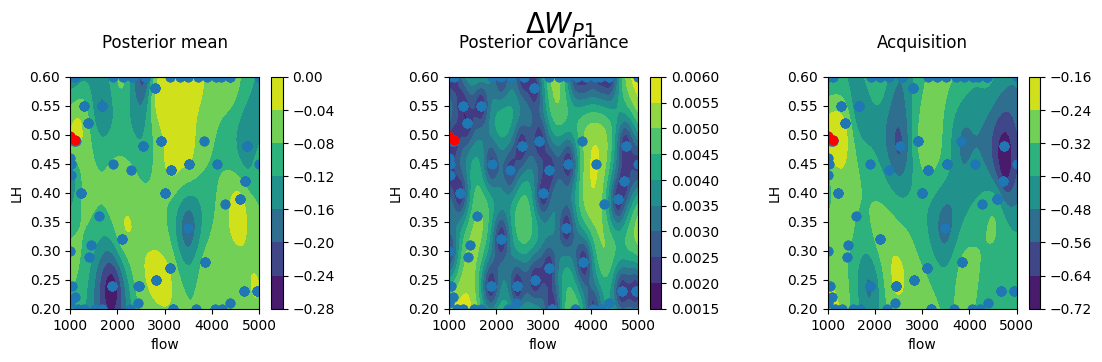

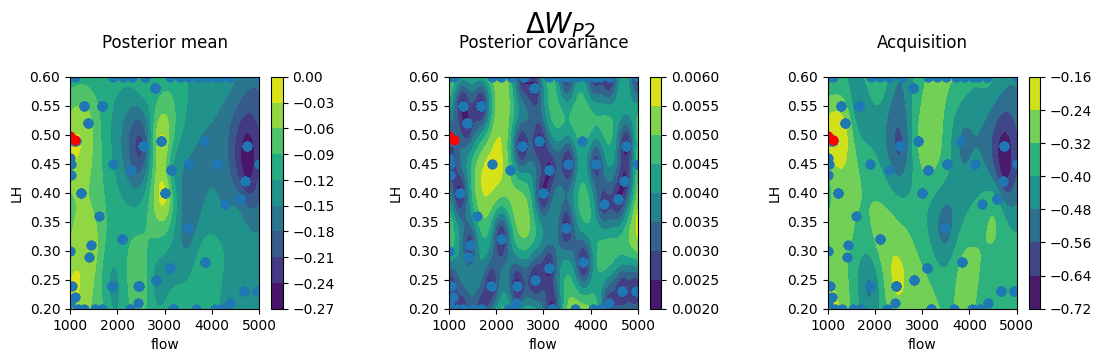

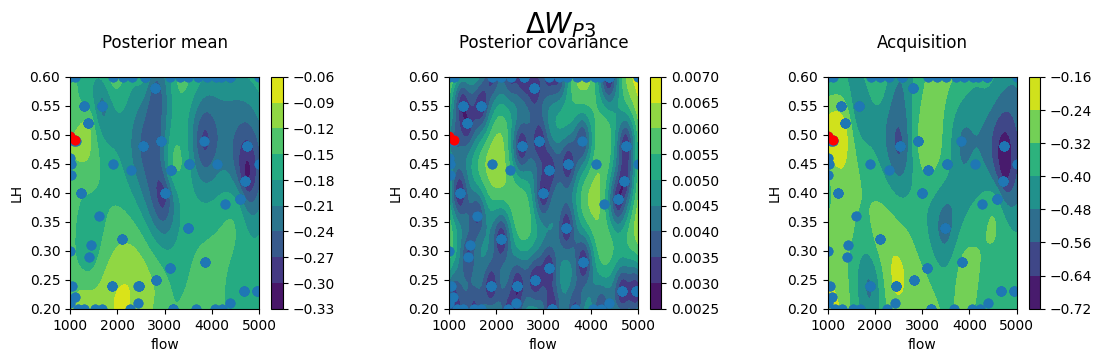

In [34]:
f_1 = my_gp.posterior_mean(x_pred, x_out = np.zeros(1) + task0)["f(x)"]
f_2 = my_gp.posterior_mean(x_pred, x_out = np.zeros(1) + task1)["f(x)"]
f_3 = my_gp.posterior_mean(x_pred, x_out = np.zeros(1) + task2)["f(x)"]

f_cov_1 = my_gp.posterior_covariance(x_pred, x_out = np.zeros(1) + task0, variance_only=False, add_noise=True)["v(x)"]
f_cov_2 = my_gp.posterior_covariance(x_pred, x_out = np.zeros(1) + task1, variance_only=False, add_noise=True)["v(x)"]
f_cov_3 = my_gp.posterior_covariance(x_pred, x_out = np.zeros(1) + task2, variance_only=False, add_noise=True)["v(x)"]

f_1_re = f_1.reshape(n_pts,n_pts)
f_2_re = f_2.reshape(n_pts,n_pts)
f_3_re = f_3.reshape(n_pts,n_pts)

f_cov_1_re = f_cov_1.reshape(n_pts,n_pts)
f_cov_2_re = f_cov_2.reshape(n_pts,n_pts)
f_cov_3_re = f_cov_3.reshape(n_pts,n_pts)

 # #Plot some results for tracking in each iteration:
title1 = "Posterior mean"
title2 = "Posterior covariance"
title3 = "Acquisition"
if is_this_a_test == 'y':
    figurepath = "./animatedfigure_2024/contourplots_composition_opt_eval_" + str(n_batch) + "_test/"
else:
    figurepath = "./animatedfigure_2024/contourplots_composition_opt_eval_" + str(n_batch) + "/"

if not os.path.exists(figurepath):
    # Create a new directory because it does not exist
    os.makedirs(figurepath)
    print("The new directory is created!")


if my_acq_func=="relative information entropy" or my_acq_func=="relative information entropy set" or my_acq_func=="total correlation":
    f_acq_1 = my_gp.evaluate_acquisition_function(x_pred, x_out = np.zeros(1)+task0, acquisition_function=my_acq_func)
    f_acq_2 = my_gp.evaluate_acquisition_function(x_pred, x_out = np.zeros(1)+task1, acquisition_function=my_acq_func)
    f_acq_3 = my_gp.evaluate_acquisition_function(x_pred, x_out = np.zeros(1)+task2, acquisition_function=my_acq_func)
    tracking_contourplot_mean_cov(X, Y, f_1_re, f_cov_1_re, np.column_stack([points[:,0], points[:,1]]), 
                                      n_batch, figurepath, title1, title2, titlexaxis="flow", titleyaxis="LH", batchsize=3, task=1, taskname = "$\Delta W_{P1}$")
    tracking_contourplot_mean_cov(X, Y, f_2_re, f_cov_2_re, np.column_stack([points[:,0], points[:,1]]), 
                                      n_batch, figurepath, title1, title2, titlexaxis="flow", titleyaxis="LH", batchsize=3, task=2, taskname = "$\Delta W_{P2}$")
    tracking_contourplot_mean_cov(X, Y, f_3_re, f_cov_3_re, np.column_stack([points[:,0], points[:,1]]), 
                                      n_batch, figurepath, title1, title2, titlexaxis="flow", titleyaxis="LH", batchsize=3, task=3, taskname = "$\Delta W_{P3}$")
    
else:
    f_acq_1 = my_gp.evaluate_acquisition_function(x_pred, x_out = np.zeros(1)+task0, acquisition_function=my_acq_func)#, points_pred = np.zeros((len(points)*len(points),2)))
    f_acq_2 = my_gp.evaluate_acquisition_function(x_pred, x_out = np.zeros(1)+task1, acquisition_function=my_acq_func)#, points_pred = np.zeros((len(points)*len(points),2)))
    f_acq_3 = my_gp.evaluate_acquisition_function(x_pred, x_out = np.zeros(1)+task2, acquisition_function=my_acq_func)#, points_pred = np.zeros((len(points)*len(points),2)))
    
    f_acq_1_re = f_acq_1.reshape(n_pts, n_pts)
    f_acq_2_re = f_acq_2.reshape(n_pts, n_pts)
    f_acq_3_re = f_acq_3.reshape(n_pts, n_pts)
    
    tracking_contourplot_mean_cov_acq(X, Y, f_1_re, f_cov_1_re, f_acq_1_re, np.column_stack([points[:,0], points[:,1]]), 
                                          n_batch, figurepath, title1, title2, title3, titlexaxis="flow", titleyaxis="LH", batchsize=3, task=1, taskname = "$\Delta W_{P1}$")
    tracking_contourplot_mean_cov_acq(X, Y, f_2_re, f_cov_2_re, f_acq_2_re, np.column_stack([points[:,0], points[:,1]]), 
                                          n_batch, figurepath, title1, title2, title3, titlexaxis="flow", titleyaxis="LH", batchsize=3, task=2, taskname = "$\Delta W_{P2}$")
    tracking_contourplot_mean_cov_acq(X, Y, f_3_re, f_cov_3_re, f_acq_3_re, np.column_stack([points[:,0], points[:,1]]), 
                                          n_batch, figurepath, title1, title2, title3, titlexaxis="flow", titleyaxis="LH", batchsize=3, task=3, taskname = "$\Delta W_{P3}$")

## 7. Save suggestions to file

In [35]:
point = points[-N_exp:]
# Run the loop
for i in range(len(point)):
    for rep_sim in [1, 2, 3]:
        weight_columns = ['W_P1', 'W_P2', 'W_P3']
        weight_column = weight_columns[random_order[rep_sim - 1] - 1]

        new_row = {
            'Flow': round(point[i][0]),
            'LH': round(point[i][1], 2),
            'Rep_seq': 1,
            'Rep_sim': rep_sim,
            'W_P1': None,
            'W_P2': None,
            'W_P3': None
        }

        new_row[weight_column] = np.nan
        df.loc[len(df)] = new_row

print(df)

       Flow    LH  Rep_sim  Rep_seq   W_P1   W_P2   W_P3
0    3000.0  0.40        1        1  3.723  4.228  5.124
1    3000.0  0.40        2        1  3.848  4.170  4.999
2    3000.0  0.40        3        1  3.893  4.127  4.988
3    3000.0  0.40        1        2  3.801  4.128  5.299
4    3000.0  0.40        2        2  4.061  4.164  5.268
..      ...   ...      ...      ...    ...    ...    ...
364  1000.0  0.50        2        1    NaN    NaN    NaN
365  1000.0  0.50        3        1    NaN    NaN    NaN
366  1108.0  0.49        1        1    NaN    NaN    NaN
367  1108.0  0.49        2        1    NaN    NaN    NaN
368  1108.0  0.49        3        1    NaN    NaN    NaN

[369 rows x 7 columns]


/var/folders/63/vmpx1vmx3s59d2ky2fm1zzww0000gp/T/ipykernel_4741/1068394849.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = new_row
/var/folders/63/vmpx1vmx3s59d2ky2fm1zzww0000gp/T/ipykernel_4741/1068394849.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = new_row
/var/folders/63/vmpx1vmx3s59d2ky2fm1zzww0000gp/T/ipykernel_4741/1068394849.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future

In [36]:
if is_this_a_test == 'y':
    fname = "./data/data-experiment-"+str(n_batch)+"_test"+".csv"
else:
    fname = "./data/data-experiment-"+str(n_batch)+".csv"
if os.path.isfile(fname):
    save_data = input("There is already a document with that name, do you want to overwrite it? y/n")
    if save_data == 'y':
        df.to_csv(fname)
else:
    df.to_csv(fname)

There is already a document with that name, do you want to overwrite it? y/n n


#### Output for all 3 tasks

In [37]:
f_all = np.column_stack([f_1, f_2, f_3])
f_all_norm = np.linalg.norm(f_all, axis=1)
f_all_norm_re = f_all_norm.reshape(n_pts,n_pts)

f_cov_all = np.column_stack([f_cov_1, f_cov_2, f_cov_3])
f_cov_all_norm = np.linalg.norm(f_cov_all, axis=1)
f_cov_all_norm_re = f_cov_all_norm.reshape(n_pts,n_pts)

### Save results to file

In [38]:
def write_results_to_file(x_pred, f_mean, f_cov, f_acq = None, filename=""):
    if f_acq:
        np.save(filename, np.column_stack([x_pred, f_mean, f_cov, f_acq]))
    else:
        np.save(filename, np.column_stack([x_pred, f_mean, f_cov]))

In [39]:
filename1 = 'Outputs/output_multiobject_alltasks_' + str(n_batch) + '.npy'
filename2 = 'Outputs/output_multiobject_task0_' + str(n_batch) + '.npy'
filename3 = 'Outputs/output_multiobject_task1_' + str(n_batch) + '.npy'
filename4 = 'Outputs/output_multiobject_task2_' + str(n_batch) + '.npy'

write_results_to_file(x_pred, f_all_norm, f_cov_all_norm, f_acq = None, filename = filename1)
write_results_to_file(x_pred, f_1, f_cov_1, f_acq = None, filename = filename2)
write_results_to_file(x_pred, f_2, f_cov_2, f_acq = None, filename = filename3)
write_results_to_file(x_pred, f_3, f_cov_3, f_acq = None, filename = filename4)

## 8. Plotting pareto front 

but better from external notebook, so need to make sure that results saved to files

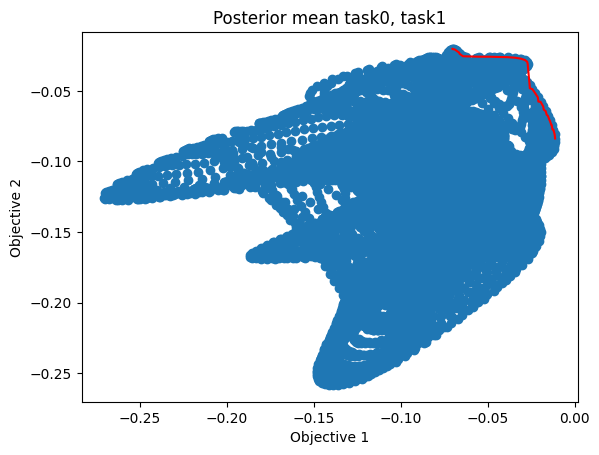

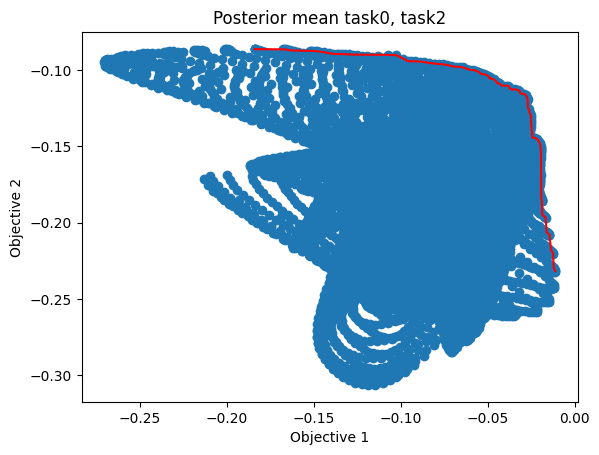

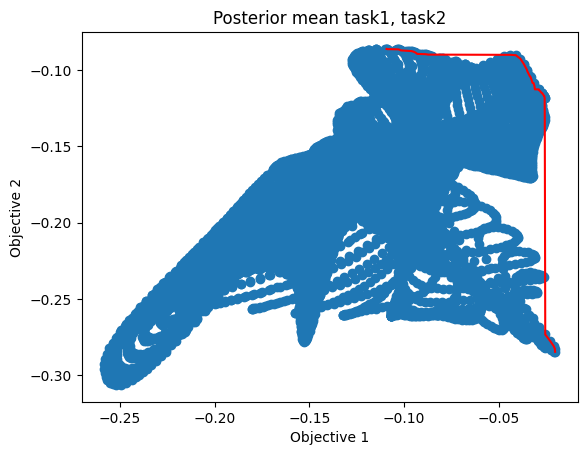

In [40]:
#slightly modified from https://sirinnes.wordpress.com/2013/04/25/pareto-frontier-graphic-via-python/:
def plot_pareto_front(Xs, Ys, maxX=True, maxY=True, title=''):
    '''Pareto front selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)
    
    '''Plotting process'''
    plt.scatter(Xs,Ys)
    pf_X = [pair[0] for pair in pareto_front]
    pf_Y = [pair[1] for pair in pareto_front]
    
    plt.plot(pf_X, pf_Y, 'r')
    plt.xlabel("Objective 1")
    plt.ylabel("Objective 2")
    plt.title(title)
    plt.show()

plot_pareto_front(f_1, f_2,title="Posterior mean task0, task1")
plot_pareto_front(f_1, f_3,title="Posterior mean task0, task2")
plot_pareto_front(f_2, f_3,title="Posterior mean task1, task2")



## 9 Capture likelihood and hps output and save metadata

In [41]:
# Step 1: Capture the printed output
output_capture = io.StringIO()
print_capture = print

# Redirect print to the StringIO object
print = lambda *args, **kwargs: print_capture(*args, **kwargs, file=output_capture)

# Call the function and capture the output
print(my_gp.log_likelihood())

# Reset print to original function
print = print_capture

# Get the printed value as a string
captured_output = output_capture.getvalue().strip()


# Step 1: Capture the printed output
output_capture_hps = io.StringIO()
print_capture_hps = print

# Redirect print to the StringIO object
print = lambda *args, **kwargs: print_capture_hps(*args, **kwargs, file=output_capture_hps)

# Call the function and capture the output
print(my_gp.get_hyperparameters())

# Reset print to original function
print = print_capture_hps

# Get the printed value as a string
captured_output_hps = output_capture_hps.getvalue().strip()

In [42]:
## Example metadata
if isinstance(my_acq_func, str):
    metadata = {
        "kernel": str(my_kernel), 
        "likelihood after BO after training": captured_output,
        "acqfunc": my_acq_func,
        "n_batch": n_batch,
        "n=1": "y",
        "gp training time stationary": time,
        "hps after BO after training": captured_output_hps,
        "order of points to printer": str(random_order),
        "values": str(values[-N_exp:]),
        "maxacq_task0": str(maxacq_task0),
        "maxacq_task1": str(maxacq_task1),
        "maxacq_task2": str(maxacq_task2)
    }
else:
    metadata = {
        "kernel": str(my_kernel), 
        "likelihood after BO after training": captured_output,
        "acqfunc": str(my_acq_func),
        "n_batch": n_batch,
        "n=1": "y",
        "gp training time stationary": time,
        "hps after BO after training": captured_output_hps,
        "order of points to printer": str(random_order),
        "values": str(values[-N_exp:]),
        "maxacq_task0": str(maxacq_task0),
        "maxacq_task1": str(maxacq_task1),
        "maxacq_task2": str(maxacq_task2)
    }
if not os.path.exists("./Metadata/"):
    # Create a new directory because it does not exist
    os.makedirs("./Metadata/")
    print("The new directory is created!")
    
# Save metadata to a YAML file
if is_this_a_test == 'y':
    with open("Metadata/metadata_after_BO" + str(n_batch) + "_test.yaml", "w") as file:
        yaml.dump(metadata, file)
else:
    with open("Metadata/metadata_after_BO" + str(n_batch) + ".yaml", "w") as file:
        yaml.dump(metadata, file)

#print("Metadata saved to metadata.yaml")